# W207 Final Project: Baseline - TalkingData AdTracking Fraud Detection

**Team:** Samantha Williams, Vincent Goldberg and Heaven Klair


## **Introduction:** 
The [Kaggle competition](https://www.kaggle.com/competitions/talkingdata-adtracking-fraud-detection/overview) we have choosen was designed to find an algorithm for TalkingData that would best predict an app download after a mobile advertisement click is made. 

TalkingData is China’s largest data service platform that covers more than 70% of all active mobile devices and processes 3 billion clicks daily with an estimated 90% of those clicks considered fraudulent or those that do not result in the download of the advertised app. This was TalkingData’s second Kaggle competition and provided users with a dataset with 200 million clicks over 4 days.

The problem that we are asked to solve is a predictive one: After clicking the ad will the user download the app? 


## **Step 1:** Import Libraries & Data

###Download Data
While we initially downloaded the data directly from Kaggle, we ultimately ended up creating our own final_training_sample.csv to save time. However, we still included the data pre-processing code (commented out) to show how that data set was created. 

In [ ]:
!pip install opendatasets --quiet
!pip install scikit-learn==1.2 --quiet

In [ ]:
# We will import every library needed for this project
import os
import time

#importing data
#import opendatasets as od

#Data processing
import numpy as np
import pandas as pd
#from pandas.core.arrays.datetimes import time
#from dython.nominal import associations

#Data visualizations
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="darkgrid")
from IPython.display import display, display_html

#ML processing 
import tensorflow as tf 
from tensorflow import keras
from keras import metrics
tf.get_logger().setLevel('INFO')

from sklearn import metrics
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.linear_model import SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import OneHotEncoder


In [ ]:
'''
Download the data sets from Kaggle directly 
This will take approx 2 minutes and 10 seconds

username: swllmsberkeley
key: ea2c9237a51cd10c6ad36b17c9215c47
'''

# od.download(
#     'https://www.kaggle.com/competitions/talkingdata-adtracking-fraud-detection/data?select=train_sample.csv')

'\nDownload the data sets from Kaggle directly \nThis will take approx 2 minutes and 10 seconds\n\nusername: swllmsberkeley\nkey: ea2c9237a51cd10c6ad36b17c9215c47\n'

### Loading Sample Training Set

In [ ]:
'''
Set the data types for the dataset that we know based on the competition details provided. 
The following features are all categorical: ip, app, device, os and channel. 
However we set the types of data for the variables to int because 
it is faster to separate the datasets into days and hours (something we will need for creating our own training set).
'''

dtypes = {
    'ip': 'uint32',
    'app': 'uint16',
    'device': 'uint16',
    'os': 'uint16',
    'channel': 'uint16',
    'click_time': 'str',
    'attributed_time': 'str',
    'is_attributed': 'uint8'
}


### Creating A Balanced Data Set

The need to create a balanced data set comes from the distribution of data provided in the original training set and the memory limitations of devices to process and train the models. The original dataset has around 200 millions of examples of clicks over the span of 4 days, and only 0.25% of 200 million (about 500,000) were instance of where a user downloads an app after clicking the adverstiment. 

To assist in creating a better model and to better maximize our resourse (RAM) we created a balanced data set that includes all the instances of when the app was downloaded from the entire training set and have downsampled records of no app downloads to match the number of reocds of app download. 

Note: We have commented out the bulk of the code used to create this file and have provided it as part of our submission to speed up the process of running this notebook. 

####Extracting Day 1 Rows


In [ ]:
'''
# set up empty dataframe to store rows from the first day
df_first_day = pd.DataFrame()

# set the start and end dates as strings
start_date = pd.to_datetime('2017-11-06 0:0:0')
end_date = pd.to_datetime('2017-11-06 23:59:59')

# convert start and end dates to Timestamp objects
start_date = pd.to_datetime(start_date)
end_date = pd.to_datetime(end_date)

# define chunksize and dtypes
chunksize = 10 ** 6


# loop over the chunks in the csv file
for chunk in pd.read_csv('/content/talkingdata-adtracking-fraud-detection/train.csv', chunksize=chunksize, dtype=dtypes, parse_dates=['click_time', 'attributed_time']):
    # filter for rows in the first day
    filtered_chunk = chunk[(chunk['click_time'] >= start_date) & (chunk['click_time'] < end_date)]
    # append filtered chunk to df_first_day
    df_first_day = pd.concat([df_first_day, filtered_chunk], ignore_index=True)
    # break the loop if the last click_time date in the chunk is greater than or equal to end_date
    if chunk.iloc[-1]['click_time'] >= end_date:
        break
        
df_first_day = df_first_day[df_first_day['is_attributed'] == 0]
'''

"\n# set up empty dataframe to store rows from the first day\ndf_first_day = pd.DataFrame()\n\n# set the start and end dates as strings\nstart_date = pd.to_datetime('2017-11-06 0:0:0')\nend_date = pd.to_datetime('2017-11-06 23:59:59')\n\n# convert start and end dates to Timestamp objects\nstart_date = pd.to_datetime(start_date)\nend_date = pd.to_datetime(end_date)\n\n# define chunksize and dtypes\nchunksize = 10 ** 6\n\n\n# loop over the chunks in the csv file\nfor chunk in pd.read_csv('/content/talkingdata-adtracking-fraud-detection/train.csv', chunksize=chunksize, dtype=dtypes, parse_dates=['click_time', 'attributed_time']):\n    # filter for rows in the first day\n    filtered_chunk = chunk[(chunk['click_time'] >= start_date) & (chunk['click_time'] < end_date)]\n    # append filtered chunk to df_first_day\n    df_first_day = pd.concat([df_first_day, filtered_chunk], ignore_index=True)\n    # break the loop if the last click_time date in the chunk is greater than or equal to end_date

In [ ]:
# len(df_first_day) # should get 9290407 rows

####Extracting Day 2 Rows

In [ ]:
'''# define start and end dates for the second day
start_date_2 = '2017-11-07'
end_date_2 = pd.to_datetime('2017-11-07 23:59:59')

start_date = pd.to_datetime(start_date_2)
end_date = pd.to_datetime(end_date_2)

# set up empty dataframe to store data for second day
df_second_day = pd.DataFrame()

# set up loop to read the data in chunks and extract rows for the second day
for chunk in pd.read_csv('/content/talkingdata-adtracking-fraud-detection/train.csv', chunksize=chunksize, dtype=dtypes, parse_dates=['click_time', 'attributed_time']):
    # filter rows for the second day
    filtered = chunk[(chunk['click_time'] >= start_date_2) & (chunk['click_time'] <= end_date_2)]
    # add filtered rows to the dataframe for the second day
    df_second_day = pd.concat([df_second_day, filtered], ignore_index=True)
    # break the loop if the last click_time date in the chunk is greater than or equal to end_date_2
    if chunk.iloc[-1]['click_time'] >= end_date_2:
        break

df_second_day = df_second_day[df_second_day['is_attributed'] == 0]'''


"# define start and end dates for the second day\nstart_date_2 = '2017-11-07'\nend_date_2 = pd.to_datetime('2017-11-07 23:59:59')\n\nstart_date = pd.to_datetime(start_date_2)\nend_date = pd.to_datetime(end_date_2)\n\n# set up empty dataframe to store data for second day\ndf_second_day = pd.DataFrame()\n\n# set up loop to read the data in chunks and extract rows for the second day\nfor chunk in pd.read_csv('/content/talkingdata-adtracking-fraud-detection/train.csv', chunksize=chunksize, dtype=dtypes, parse_dates=['click_time', 'attributed_time']):\n    # filter rows for the second day\n    filtered = chunk[(chunk['click_time'] >= start_date_2) & (chunk['click_time'] <= end_date_2)]\n    # add filtered rows to the dataframe for the second day\n    df_second_day = pd.concat([df_second_day, filtered], ignore_index=True)\n    # break the loop if the last click_time date in the chunk is greater than or equal to end_date_2\n    if chunk.iloc[-1]['click_time'] >= end_date_2:\n        break\n\n

In [ ]:
# len(df_second_day) 

#### Extracting Day 3 Rows

In [ ]:
'''# define start and end dates for the third day
start_date_3 = '2017-11-08'
end_date_3 = pd.to_datetime('2017-11-08 23:59:59')

start_date = pd.to_datetime(start_date_3)
end_date = pd.to_datetime(end_date_3)

# set up empty dataframe to store data for third day
df_third_day = pd.DataFrame()

# set up loop to read the data in chunks and extract rows for the third day
for chunk in pd.read_csv('/content/talkingdata-adtracking-fraud-detection/train.csv', chunksize=chunksize, dtype=dtypes, parse_dates=['click_time', 'attributed_time']):
    # filter rows for the third day
    filtered = chunk[(chunk['click_time'] >= start_date_3) & (chunk['click_time'] <= end_date_3)]
    # add filtered rows to the dataframe for the third day
    df_third_day = pd.concat([df_third_day, filtered], ignore_index=True)
    # break the loop if the last click_time date in the chunk is greater than or equal to end_date_3
    if chunk.iloc[-1]['click_time'] >= end_date_3:
        break
  
df_third_day = df_third_day[df_third_day['is_attributed'] == 0]'''


"# define start and end dates for the third day\nstart_date_3 = '2017-11-08'\nend_date_3 = pd.to_datetime('2017-11-08 23:59:59')\n\nstart_date = pd.to_datetime(start_date_3)\nend_date = pd.to_datetime(end_date_3)\n\n# set up empty dataframe to store data for third day\ndf_third_day = pd.DataFrame()\n\n# set up loop to read the data in chunks and extract rows for the third day\nfor chunk in pd.read_csv('/content/talkingdata-adtracking-fraud-detection/train.csv', chunksize=chunksize, dtype=dtypes, parse_dates=['click_time', 'attributed_time']):\n    # filter rows for the third day\n    filtered = chunk[(chunk['click_time'] >= start_date_3) & (chunk['click_time'] <= end_date_3)]\n    # add filtered rows to the dataframe for the third day\n    df_third_day = pd.concat([df_third_day, filtered], ignore_index=True)\n    # break the loop if the last click_time date in the chunk is greater than or equal to end_date_3\n    if chunk.iloc[-1]['click_time'] >= end_date_3:\n        break\n  \ndf_thi

In [ ]:
# len(df_third_day)

####Extracting Day 4 Rows

In [ ]:
'''# define start and end dates for the fourth day
start_date_4 = '2017-11-09'
end_date_4 = pd.to_datetime('2017-11-09 23:59:59')

start_date = pd.to_datetime(start_date_4)
end_date = pd.to_datetime(end_date_4)

# set up empty dataframe to store data for fourth day
df_fourth_day = pd.DataFrame()

# set up loop to read the data in chunks and extract rows for the fourth day
for chunk in pd.read_csv('/content/talkingdata-adtracking-fraud-detection/train.csv', chunksize=chunksize, dtype=dtypes, parse_dates=['click_time', 'attributed_time']):
    # filter rows for the fourth day
    filtered = chunk[(chunk['click_time'] >= start_date_4) & (chunk['click_time'] <= end_date_4)]
    # add filtered rows to the dataframe for the fourth day
    df_fourth_day = pd.concat([df_fourth_day, filtered], ignore_index=True)
    # break the loop if the last click_time date in the chunk is greater than or equal to end_date_4
    if chunk.iloc[-1]['click_time'] >= end_date_4:
        break

df_fourth_day = df_fourth_day[df_fourth_day['is_attributed'] == 0]
'''

"# define start and end dates for the fourth day\nstart_date_4 = '2017-11-09'\nend_date_4 = pd.to_datetime('2017-11-09 23:59:59')\n\nstart_date = pd.to_datetime(start_date_4)\nend_date = pd.to_datetime(end_date_4)\n\n# set up empty dataframe to store data for fourth day\ndf_fourth_day = pd.DataFrame()\n\n# set up loop to read the data in chunks and extract rows for the fourth day\nfor chunk in pd.read_csv('/content/talkingdata-adtracking-fraud-detection/train.csv', chunksize=chunksize, dtype=dtypes, parse_dates=['click_time', 'attributed_time']):\n    # filter rows for the fourth day\n    filtered = chunk[(chunk['click_time'] >= start_date_4) & (chunk['click_time'] <= end_date_4)]\n    # add filtered rows to the dataframe for the fourth day\n    df_fourth_day = pd.concat([df_fourth_day, filtered], ignore_index=True)\n    # break the loop if the last click_time date in the chunk is greater than or equal to end_date_4\n    if chunk.iloc[-1]['click_time'] >= end_date_4:\n        break\n\n

In [ ]:
# len(df_fourth_day)

#### Merge Each Day Into Dataset 
We will merge each day into onde dataset according to their proportion of records. 

In [ ]:
'''prop_day1 = 9290407 / 190000000
prop_day2 = 59481146 / 190000000
prop_day3 = 62791754 / 190000000
prop_day4 = 52882970 / 190000000

# Calculate the number of rows to sample from each day by multiplying the proportion 
# with the desired total number of rows
num_sample_day1 = int(500000 * prop_day1)
num_sample_day2 = int(500000 * prop_day2)
num_sample_day3 = int(500000 * prop_day3)
num_sample_day4 = int(500000 * prop_day4)'''

'prop_day1 = 9290407 / 190000000\nprop_day2 = 59481146 / 190000000\nprop_day3 = 62791754 / 190000000\nprop_day4 = 52882970 / 190000000\n\n# Calculate the number of rows to sample from each day by multiplying the proportion \n# with the desired total number of rows\nnum_sample_day1 = int(500000 * prop_day1)\nnum_sample_day2 = int(500000 * prop_day2)\nnum_sample_day3 = int(500000 * prop_day3)\nnum_sample_day4 = int(500000 * prop_day4)'

In [ ]:
'''# sample the desired number of rows from each day's data frame
sample_day1 = df_first_day.sample(num_sample_day1) 
sample_day2 = df_second_day.sample(num_sample_day2)
sample_day3 = df_third_day.sample(num_sample_day3)
sample_day4 = df_fourth_day.sample(num_sample_day4)'''

"# sample the desired number of rows from each day's data frame\nsample_day1 = df_first_day.sample(num_sample_day1) \nsample_day2 = df_second_day.sample(num_sample_day2)\nsample_day3 = df_third_day.sample(num_sample_day3)\nsample_day4 = df_fourth_day.sample(num_sample_day4)"

In [ ]:
# df_no_app_download = pd.concat([sample_day1, sample_day2, sample_day3, sample_day4]) 

In [ ]:
# len(df_no_app_download)

####Extracting Data When The App Was Downloaded

Creating a dataset of records from the full training set where the app was downloaded.

In [ ]:
'''#This takes around 2 mintues to execute to completion 
train_dlapp = pd.DataFrame()
chunksize = 10**6

#in each chunk, filter for values that have 'is_attributed'==1, and merge these values into one dataframe
for chunk in pd.read_csv('/content/talkingdata-adtracking-fraud-detection/train.csv', chunksize=chunksize, dtype=dtypes):
    filtered = (chunk[(np.where(chunk['is_attributed']==1, True, False))])
    train_dlapp = pd.concat([train_dlapp, filtered], ignore_index=True, )'''


"#This takes around 2 mintues to execute to completion \ntrain_dlapp = pd.DataFrame()\nchunksize = 10**6\n\n#in each chunk, filter for values that have 'is_attributed'==1, and merge these values into one dataframe\nfor chunk in pd.read_csv('/content/talkingdata-adtracking-fraud-detection/train.csv', chunksize=chunksize, dtype=dtypes):\n    filtered = (chunk[(np.where(chunk['is_attributed']==1, True, False))])\n    train_dlapp = pd.concat([train_dlapp, filtered], ignore_index=True, )"

In [ ]:
'''#Sanity Check that this worked
train_dlapp.info()
print(len(train_dlapp))'''

'#Sanity Check that this worked\ntrain_dlapp.info()\nprint(len(train_dlapp))'

### Storing Final Dataset

Storing the final dataset as a CSV file in the datasets folder

In [ ]:
# final_train_dataset = pd.concat([df_no_app_download, train_dlapp], ignore_index=True)
# final_train_data.to_csv('/Users/leon/Documents/Berkeley/w207/finalProject/dataSets/final_training_sample.csv')
# len(final_train_dataset)    942229

### Loading the Balanced Dataset

After we created the balanced dataset, we saved it on a CSV file so that we do not lose the progress once the Colab's session run out. In the cell below we have loaded the saved CSV file of the balanced dataset.

In [ ]:
# train_sample = pd.read_csv('/content/train_sample.csv', dtype=dtypes) # Do we need to load this?

final_training_sample = pd.read_csv('/content/final_training_sample.csv', dtype=dtypes)

## **Step 2:** Initial Inspection of Data
For reference, TalkingData has provided details about the information contatined in the data set. Each row of the training data contains a click record, with the following features. Note that ip, app, device, os, and channel are encoded and the actual value it corresponds to is unknown. Additionally, the columns click_time and attributed_time are objects that will need to be converted to a data/time format that is useable for our analysis.

*   **ip:** ip address of click
*   **app:** app id for marketing
*   **device:** device type id of user mobile phone (e.g., iphone 6 plus, iphone 7, huawei mate 7, etc.)
*   **os:** os version id of user mobile phone
*   **channel:** channel id of mobile ad publisher
*   **click_time:** timestamp of click (UTC)
*   **attributed_time:** if user download the app for after clicking an ad, this is the time of the app download
*   **is_attributed:** the target that is to be predicted, indicating the app was downloaded

The test data is similar, with the following differences:
*   **click_id:** reference for making predictions
*   **is_attributed:** not included in the data set


### Training Sample: Inspection and Adjustments of the Data

In [ ]:
print('Final Training Set:')
final_training_sample.info()

Final Training Set:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 942229 entries, 0 to 942228
Data columns (total 8 columns):
 #   Column           Non-Null Count   Dtype 
---  ------           --------------   ----- 
 0   ip               942229 non-null  uint32
 1   app              942229 non-null  uint16
 2   device           942229 non-null  uint16
 3   os               942229 non-null  uint16
 4   channel          942229 non-null  uint16
 5   click_time       942229 non-null  object
 6   attributed_time  456846 non-null  object
 7   is_attributed    942229 non-null  uint8 
dtypes: object(2), uint16(4), uint32(1), uint8(1)
memory usage: 26.1+ MB


In [ ]:
final_training_sample.head(10)

,ip,app,device,os,channel,click_time,attributed_time,is_attributed
0,36183,12,1,3,245,2017-11-06 23:32:20,NaN,0
1,77792,15,1,17,265,2017-11-06 16:22:50,NaN,0
2,147957,9,1,19,232,2017-11-06 22:22:34,NaN,0
3,28082,15,1,19,245,2017-11-06 21:00:04,NaN,0
4,105128,12,1,13,245,2017-11-06 23:04:56,NaN,0
5,108942,15,1,13,245,2017-11-06 16:23:49,NaN,0
6,35182,3,1,19,280,2017-11-06 16:05:11,NaN,0
7,45971,9,1,19,334,2017-11-06 23:57:58,NaN,0
8,183683,2,1,19,435,2017-11-06 20:25:40,NaN,0
9,88923,15,1,6,140,2017-11-06 17:05:05,NaN,0


In [ ]:
#Looking for null values in places we do not expect
print(final_training_sample.isnull().sum())

ip                      0
app                     0
device                  0
os                      0
channel                 0
click_time              0
attributed_time    485383
is_attributed           0
dtype: int64


In [ ]:
# Viewing downloads vs no downloads

no_download = final_training_sample['is_attributed'].value_counts()[0]
total_downloads = final_training_sample['is_attributed'].value_counts()[1]
print('Total downloads:\t', total_downloads)
print('No downloads:\t\t', no_download)

Total downloads:	 456846
No downloads:		 485383


## **Step 3:** Visual Data Exploration

Now, we have loaded the balanced dataset, and are ready to proceed further to inspect it.

### Visualizing uniques values per feature in the data 

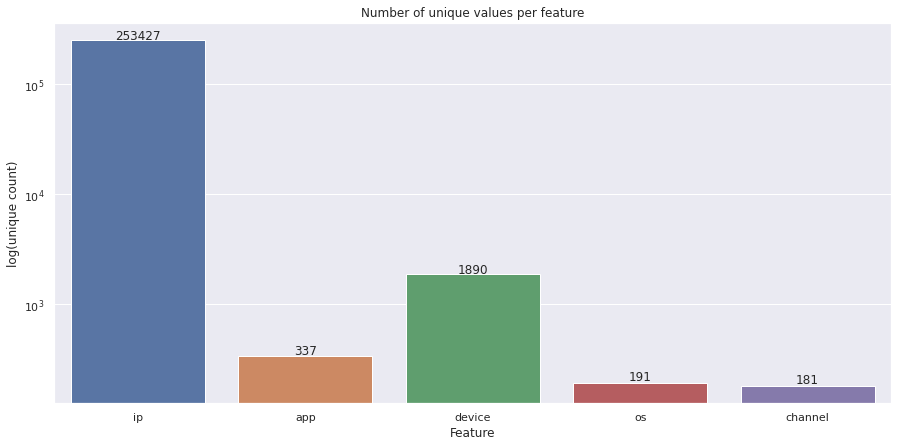

In [ ]:
plt.figure(figsize=(15, 7))
cols = ['ip', 'app', 'device', 'os', 'channel']

uniques = [len(final_training_sample[col].unique()) for col in cols] # calculates the number of unique values in each column using len function

# sns.set(font_scale = 1.5) # sets the font size of the plot 
ax = sns.barplot(x=cols, y=uniques, log=True) # plots the y-axis on a logarithmic scale
ax.set(xlabel='Feature', ylabel='log(unique count)', title='Number of unique values per feature') # setting labels on the axis


# loop adds text labels above each bar in the plot, showing the exact number of unique values for each variable
for p, uniq in zip(ax.patches, uniques):
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2.,
            height + 10,
            uniq,
            ha="center") 

We can conclude that `ip` (Network Address) has the most unique values, followed by the `device` (device type id of user mobile phone), `app` (app id for marketing), `os` (os version id of user mobile phone), and `channel` (channel id of mobile ad publisher).

This could be useful to know as this gives a rough count of how many unique values we have for every single column in the dataset.

### Visualize the proportions of app downloads and app not downloads

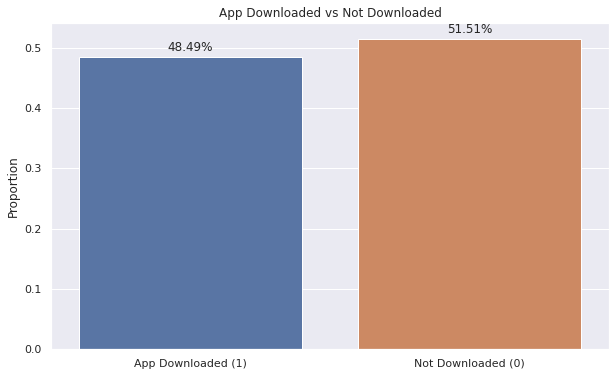

In [ ]:
plt.figure(figsize=(10,6))

mean = (final_training_sample["is_attributed"] == 1).mean()

# creates plot with the proportion of app downloads and not downloads as the y-axis and the two categories on the x-axis
ax = sns.barplot(x=['App Downloaded (1)', 'Not Downloaded (0)'], y=[mean, 1-mean])
ax.set(ylabel='Proportion', title='App Downloaded vs Not Downloaded')

# add labels to each bar in the plot for the percentage of clicks that resulted in an app download and those that did not
for p, uniq in zip(ax.patches, [mean, 1-mean]):
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2.,
            height+0.01,
            '{}%'.format(round(uniq * 100, 2)),
            ha="center")

Since we balanced our dataset from the original dataset, we should have similiar counts of instances where the app was downloaded and where the app was not donwloaded. We see in the above plot, that 48.49% of the dataset represents examples where the app was downloaded and 51.51% of data represent examples where app was not donwloaded. Thus we can say that it is pretty balanced dataset for our needs. 

### Checking IP counts

Count of clicks for each unique IP address in the dataframe and sort them in descending order

In [ ]:
# Table to see ips with their associated count frequencies
temp = final_training_sample['ip'].value_counts().reset_index(name='total_click_counts')
temp.columns = ['ip', 'counts']

temp = temp.sort_values('counts', ascending=False)

temp[:10]

,ip,counts
0,5348,5633
1,5314,5293
2,73516,3085
3,73487,3063
4,53454,1464
5,95766,1381
6,26995,1347
7,114276,1188
8,100275,1085
9,105475,1080


We can see that there are some IP addresses that triggers a click over 5000 times over the span of 4 days. This is an unusual behavior as to why would one IP address click that many times in just 4 days. Certainly, it opens up the door to the possiblitity that there is some fradulent activity (bots clicking the ads) going on in the clicks recieved by the ads.

### IP Addresses versus Click counts (is_attribuetd == 1)

Checking if there are some IP addresses that are contributing to the click counts more than other

In [ ]:
# group the data by ip and count the number of clicks for each ip
ip_click_counts = final_training_sample[final_training_sample['is_attributed'] == 1].groupby('ip')['is_attributed'].count().reset_index(name='click_count_of_downloaded_apps')

# sort the results in descending order
ip_click_counts = ip_click_counts.sort_values(by='click_count_of_downloaded_apps', ascending=False)

# print the top 10 ip addresses with the most clicks
print(ip_click_counts.head(10))

           ip  click_count_of_downloaded_apps
1505     5348                            2340
1493     5314                            2200
20538   73487                            1091
20547   73516                            1025
1454     5178                             436
1447     5147                             399
26640   95766                             379
4232    15195                             367
27870  100275                             357
30770  110300                             350


The same `ip` addresses that received the most clicks are also receiving the highest click downloads within a span of 4 days. We need to investigate further to determine what we can deduce from these results. However, this certainly raises suspicions of fraudulent activity.

### Conversion rates over Counts of 300 most popular IPs

* The mean of `is_attributed` can tell us the percentage of clicks that resulted in an app download for every `ip`. Even though the values in the `is_attributed` column are only 1 and 0, we can still calculate the mean of that column. When we take the mean of a binary variable like `is_attributed`, the resulting value represents the proportion of the observations that have a value of 1.

* By counting the number of clicks for each `ip`, we can get a sense of how many clicks each `ip` is responsible for. Additionally, having the count of clicks can give us a better sense of the overall volume of clicks for each ip.

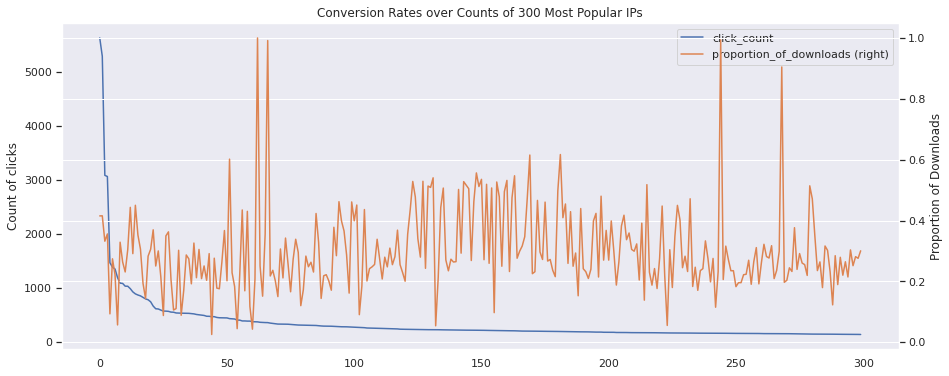

In [ ]:
# extracts 'ip' and 'is_attributed' from the dataset and groups them by 'ip' and then calculates the 
# mean of 'is_attributed' for each 'ip'. Then sort them in desc order according the 'is_attributed' column
proportion = final_training_sample[['ip', 'is_attributed']].groupby('ip', as_index=False).mean().sort_values('is_attributed', ascending=False)

# same as line 1 but it counts the number of clicks for each 'ip'
counts = final_training_sample[['ip', 'is_attributed']].groupby('ip', as_index=False).count().sort_values('is_attributed', ascending=False)

# merges the two dfs (counts and proportion) based on the 'ip' column. 
merge = counts.merge(proportion, on='ip', how='left')

# The result is a df with three columns: 'ip', 'click_count', and 'prop_downloaded'
merge.columns = ['ip', 'click_count', 'proportion_of_downloads']

# Remove the 'ip'
merge = merge[['click_count', 'proportion_of_downloads']]

# Plot the data
ax = merge[:300].plot(secondary_y='proportion_of_downloads', figsize=(15,6))
plt.title('Conversion Rates over Counts of 300 Most Popular IPs')
ax.set(ylabel='Count of clicks')
plt.ylabel('Proportion of Downloads')
plt.show()

**Inference from the plot:**

* The plot shows the relationship between the count of clicks and the proportion of downloads (`is_attributed`=1) for the 300 most popular IPs in the dataset.

* We can see that for the IPs with the highest count of clicks, the proportion of downloads varies widely, from 0 to 0.4%. This suggests that the number of clicks alone is not a reliable indicator of the proportion of downloads.

### Conversions by App

Check 100 most popular apps by click count:

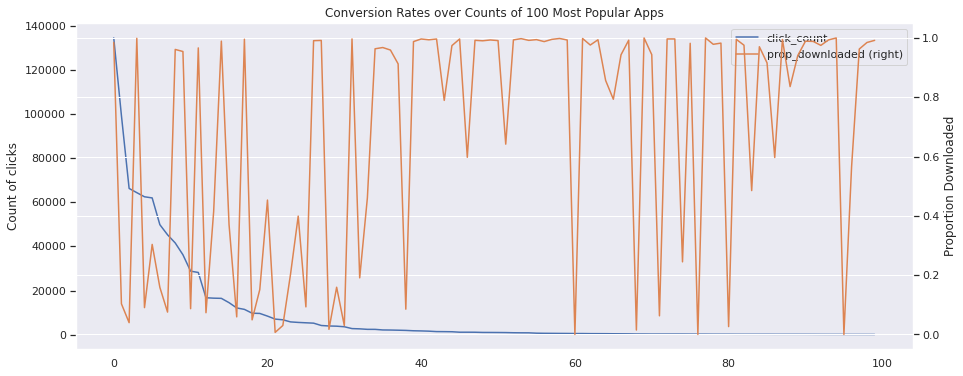

In [ ]:
# Using similar code as above
proportion = final_training_sample[['app', 'is_attributed']].groupby('app', as_index=False).mean().sort_values('is_attributed', ascending=False)
counts = final_training_sample[['app', 'is_attributed']].groupby('app', as_index=False).count().sort_values('is_attributed', ascending=False)
merge = counts.merge(proportion, on='app', how='left')
merge.columns = ['app', 'click_count', 'prop_downloaded']

# Remove the 'app'
merge = merge[['click_count', 'prop_downloaded']]

ax = merge[:100].plot(secondary_y='prop_downloaded', figsize=(15,6))
plt.title('Conversion Rates over Counts of 100 Most Popular Apps')
ax.set(ylabel='Count of clicks')
plt.ylabel('Proportion Downloaded')
plt.show()

The plot shows the relationship between the count of clicks and the proportion of downloads (`is_attributed`=1) for the 100 most popular apps in the dataset. Again, there does not seem to any correlation between the click counts and the proportion of downloads for apps. The `prop_downloaded` fluctuates a lot, and it does not point us to a conclusion.

### Conversions by os

Check 100 most popular os by click count:

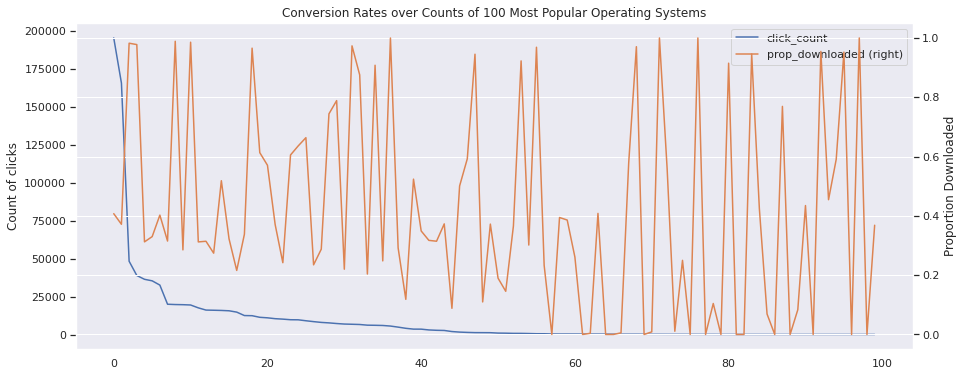

In [ ]:
proportion = final_training_sample[['os', 'is_attributed']].groupby('os', as_index=False).mean().sort_values('is_attributed', ascending=False)
counts = final_training_sample[['os', 'is_attributed']].groupby('os', as_index=False).count().sort_values('is_attributed', ascending=False)
merge = counts.merge(proportion, on='os', how='left')
merge.columns = ['os', 'click_count', 'prop_downloaded']

# Remove the 'os'
merge = merge[['click_count', 'prop_downloaded']]
ax = merge[:100].plot(secondary_y='prop_downloaded', figsize=(15,6))
plt.title('Conversion Rates over Counts of 100 Most Popular Operating Systems')
ax.set(ylabel='Count of clicks')
plt.ylabel('Proportion Downloaded')
plt.show()

The plot shows the relationship between the count of clicks and the proportion of downloads (`is_attributed`=1) for the 100 most popular `os` in the dataset. Again, there does not seem to any correlation between the click counts and the proportion of downloads for apps.

### Conversions by device

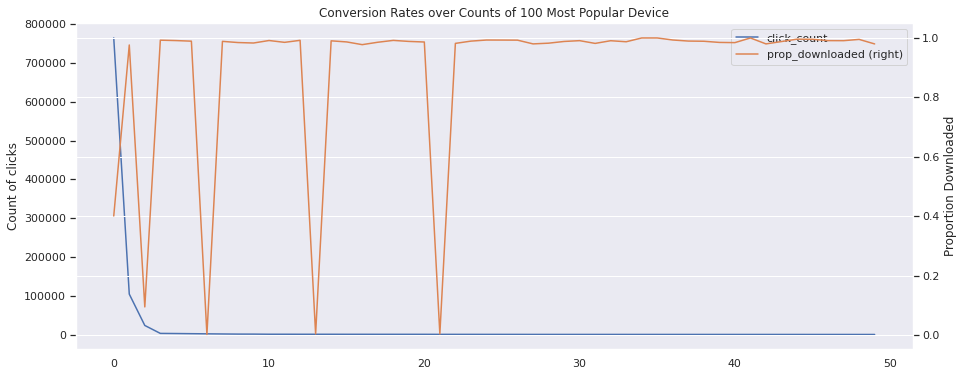

In [ ]:
proportion = final_training_sample[['device', 'is_attributed']].groupby('device', as_index=False).mean().sort_values('is_attributed', ascending=False)
counts = final_training_sample[['device', 'is_attributed']].groupby('device', as_index=False).count().sort_values('is_attributed', ascending=False)
merge = counts.merge(proportion, on='device', how='left')
merge.columns = ['device', 'click_count', 'prop_downloaded']

# Remove the 'os'
merge = merge[['click_count', 'prop_downloaded']]
ax = merge[:50].plot(secondary_y='prop_downloaded', figsize=(15,6))
plt.title('Conversion Rates over Counts of 100 Most Popular Device')
ax.set(ylabel='Count of clicks')
plt.ylabel('Proportion Downloaded')
plt.show()

Devices are extremely disproportionately distributed, with number one device used most of time. For device 0, proportion download was 0.4 (or 4%).

In [ ]:
merge = merge.sort_values(by='click_count', ascending=False)
merge

,click_count,prop_downloaded
0,764453,0.400934
1,104282,0.976362
2,23423,0.094907
3,2959,0.992565
4,2628,0.991248
...,...,...
1386,1,1.000000
1387,1,1.000000
1388,1,1.000000
1389,1,1.000000


We can infer that device 0 got the most click counts (764453), with the conversion rate is of just 4% whereas the device 2 got 104282 click counts and it has a conversion rate of 9.7%. There is not a general trend, but this information could be useful for building the model later.

The plots shows high conversion rates of each device. In the real life, most of the people only have one out of the main 10 phones in the market. That is what we can think of here. People in China would be using phones that are mainstream in their market. Out of the phones that are mainstream in the market, most of them are high conversion rates while every few people (less than a percent) using rare phones. This is useful because at least we now know that people are using the mainstream devices for clicking the ads.

### Conversions by channel

     channel  click_count  prop_downloaded
0        213       134696         0.987928
1        113        56958         0.980828
2        280        43682         0.093288
3         21        43118         0.984948
4        101        38762         0.855890
..       ...          ...              ...
176      169            1         1.000000
177      216            1         1.000000
178      223            1         1.000000
179      458            1         1.000000
180      172            1         0.000000

[181 rows x 3 columns]


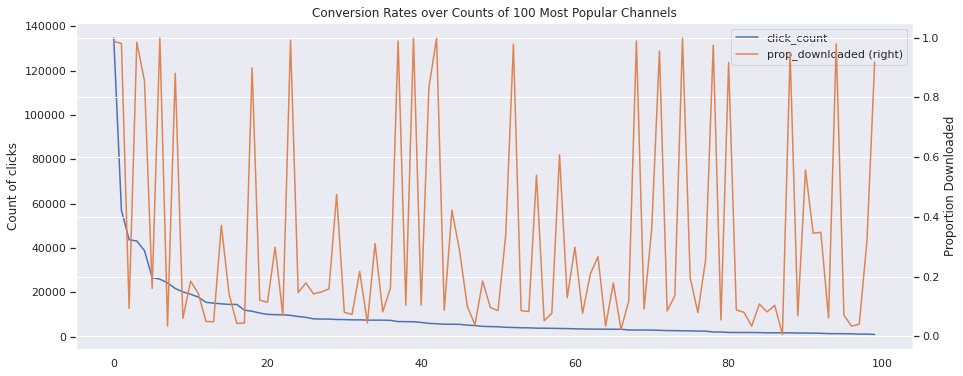

In [ ]:
proportion = final_training_sample[['channel', 'is_attributed']].groupby('channel', as_index=False).mean().sort_values('is_attributed', ascending=False)
counts = final_training_sample[['channel', 'is_attributed']].groupby('channel', as_index=False).count().sort_values('is_attributed', ascending=False)
merge = counts.merge(proportion, on='channel', how='left')
merge.columns = ['channel', 'click_count', 'prop_downloaded']
print(merge.sort_values(by='click_count', ascending=False))

# Remove the 'channel'
merge = merge[['click_count', 'prop_downloaded']]
ax = merge[:100].plot(secondary_y='prop_downloaded', figsize=(15,6))
plt.title('Conversion Rates over Counts of 100 Most Popular Channels')
ax.set(ylabel='Count of clicks')
plt.ylabel('Proportion Downloaded')
plt.show()

We see the same story here - there are fluctuations in the plot. It is hard to say that some channels contribute more to the fradulent clicks than others. It requires more investigation. We checked every association with devices, but we could not find any correlation with the conversion rates. Thus we proceed to explore time patterns.

### Exploring Time-Based Trends in the Data

We need to see what works best for us: splitting time based on hours, minutes, or some other quantity. Let us start with hours first:

In [ ]:
final_training_sample['click_time'] = pd.to_datetime(final_training_sample['click_time'])
final_training_sample['attributed_time'] = pd.to_datetime(final_training_sample['attributed_time'])

In [ ]:
final_training_sample_v2 = final_training_sample # making a copy of the training dataset

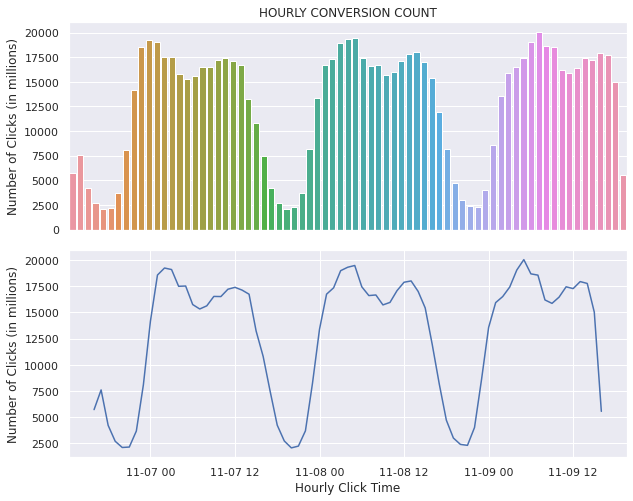

In [ ]:
# round the time to nearest hour
final_training_sample_v2['hourly_click_time'] = final_training_sample_v2['click_time'].dt.round('H')

# create figure and axes objects
fig, axes = plt.subplots(2, 1, figsize=(10, 8))

# plot the first plot using sns.barplot
sns.barplot(x='hourly_click_time', y='is_attributed', data=final_training_sample_v2.groupby(['hourly_click_time'], as_index=True).count().reset_index(), ax=axes[0])
axes[0].set_title('HOURLY CONVERSION COUNT')
axes[0].set_ylabel('Number of Clicks (in millions)')
axes[0].set(xticks=[])
axes[0].set(xlabel=None)

# plot the second plot using sns.lineplot
sns.lineplot(x='hourly_click_time', y='is_attributed', data=final_training_sample_v2.groupby(['hourly_click_time'], as_index=True).count(), ax=axes[1])
# axes[1].set_title('HOURLY CONVERSION COUNT')
axes[1].set_xlabel('Hourly Click Time')
axes[1].set_ylabel('Number of Clicks (in millions)')

# adjust spacing between plots
plt.subplots_adjust(hspace=0.1)

# show the plot
plt.show()

**Inference from the plots:**

* We can clearly visualize the trend in the plots - the number of clicks increases during the start of the day (right at midnight), and they remain consistent for the most part of the day, and then decreases as the day starts to end (around 2 pm). This is consistent trend for all the given dates.

* This means that we can utilize the hours of the click_time to gather information about the conversion ratios.

### Checking Conversion Rates

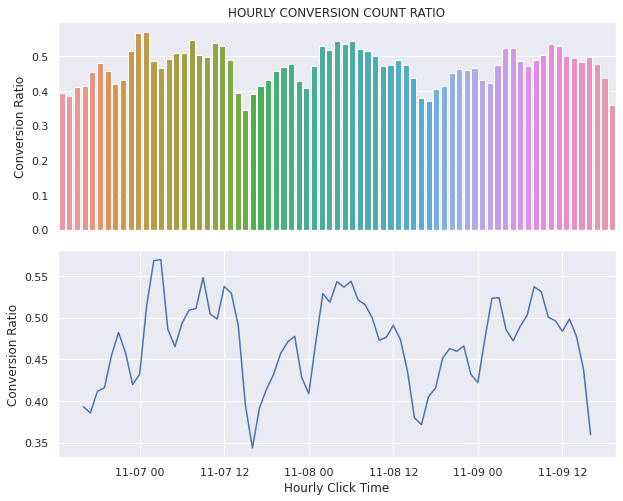

In [ ]:
# create figure and axes objects
fig, axes = plt.subplots(2, 1, figsize=(10, 8))

# plot the first plot using sns.barplot
sns.barplot(x='hourly_click_time', y='is_attributed', data=final_training_sample_v2.groupby(['hourly_click_time'], as_index=True).mean().reset_index(), ax=axes[0])
axes[0].set_title('HOURLY CONVERSION COUNT RATIO')
axes[0].set_ylabel('Conversion Ratio')
axes[0].set(xticks=[])
axes[0].set(xlabel=None)

# plot the second plot using sns.lineplot
sns.lineplot(x='hourly_click_time', y='is_attributed', data=final_training_sample_v2.groupby(['hourly_click_time'], as_index=True).mean(), ax=axes[1])
# axes[1].set_title('HOURLY CONVERSION COUNT')
axes[1].set_xlabel('Hourly Click Time')
axes[1].set_ylabel('Conversion Ratio')

# adjust spacing between plots
plt.subplots_adjust(hspace=0.1)

# show the plot
plt.show()

**Inference from the plot**:

* We can see that the conversion rates tend to follow a similar pattern just like the click counts. The conversion decrease when the click count decrease, the conversion rate increases when the click count increase. 

### EDA using hours as a new feature in the dataset

Number of Clicks by Hours:

* Extracts the hour component from the 'hourly_click_time' column of the DataFrame df_7_8_day and replaces the hourly_click_time column with it. 
* The resulting hourly_click_time column will contain only the hour component (0-23) of each timestamp in the original column.

In [ ]:
#extract hour as a feature
final_training_sample_v2['hourly_click_time'] = final_training_sample_v2['hourly_click_time'].dt.hour

In [ ]:
final_training_sample_v2.hourly_click_time.unique()

array([ 0, 16, 22, 21, 23, 20, 17, 19, 18, 15,  9,  7,  1, 12,  3, 10, 11,
        2,  4, 14,  5,  8,  6, 13])

`hourly_click_time` has 24 unique values stored in it, which is exactly what we would like to see.

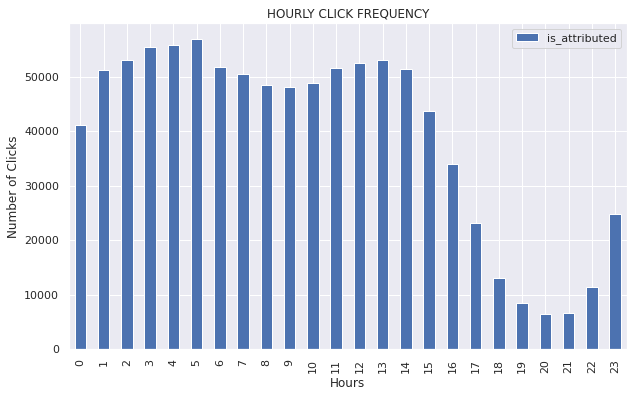

In [ ]:
fig, ax = plt.subplots(figsize=(10,6))
final_training_sample_v2[['hourly_click_time','is_attributed']].groupby(['hourly_click_time'], as_index=True).count().plot(kind='bar', ax=ax)
plt.title('HOURLY CLICK FREQUENCY')
plt.ylabel('Number of Clicks')
plt.xlabel('Hours')
plt.show()

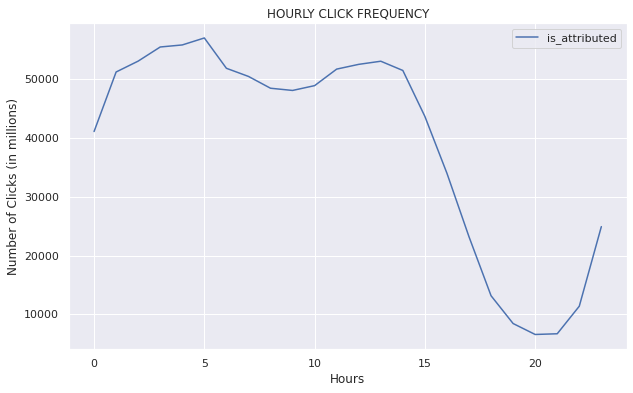

In [ ]:
fig, ax = plt.subplots(figsize=(10,6))
final_training_sample_v2[['hourly_click_time','is_attributed']].groupby(['hourly_click_time'], as_index=True).count().plot(kind='line', ax=ax)
plt.title('HOURLY CLICK FREQUENCY')
plt.ylabel('Number of Clicks (in millions)')
plt.xlabel('Hours')
plt.show()

**Inference from the plot:**

* The above plot aligns with what we described in the plot before it.

* We can clearly visualize the trend in the plots - the number of clicks increases during the start of the day (right at midnight), and they remain consistent for the most part of the day, and then decreases as the day starts to end (around 2 pm). This is consistent trend for all the given dates.

### Number of Conversions by Hours:

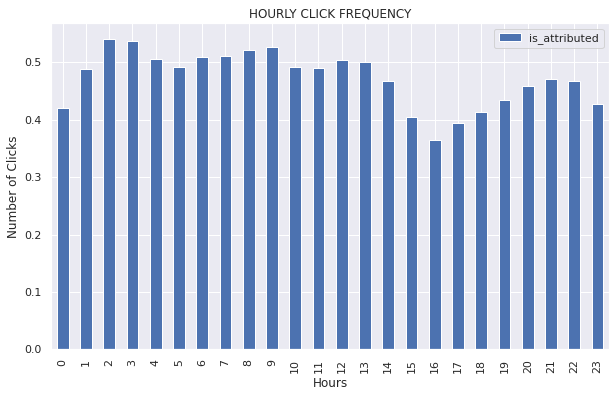

In [ ]:
fig, ax = plt.subplots(figsize=(10,6))
final_training_sample_v2[['hourly_click_time','is_attributed']].groupby(['hourly_click_time'], as_index=True).mean().plot(kind='bar',  ax=ax)
plt.title('HOURLY CLICK FREQUENCY')
plt.ylabel('Number of Clicks')
plt.xlabel('Hours')
plt.show()

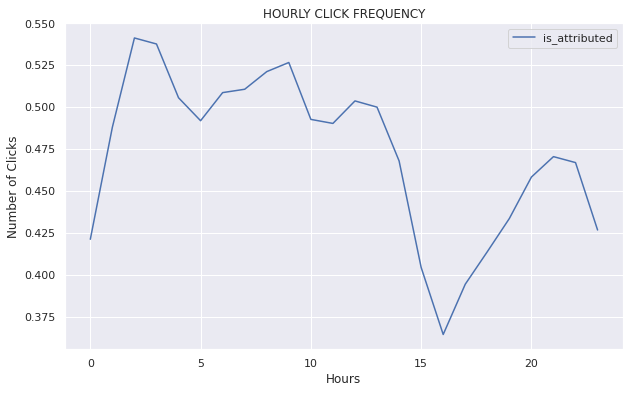

In [ ]:
fig, ax = plt.subplots(figsize=(10,6))
final_training_sample_v2[['hourly_click_time','is_attributed']].groupby(['hourly_click_time'], as_index=True).mean().plot(kind='line', ax=ax)
plt.title('HOURLY CLICK FREQUENCY')
plt.ylabel('Number of Clicks')
plt.xlabel('Hours')
plt.show()

**Inference from the plot:**

The conversion plots does not present us any visible trends as the conversion trends remains high for the most part of the day.

### Combining the Click counts and Click Conversion trends into one plot

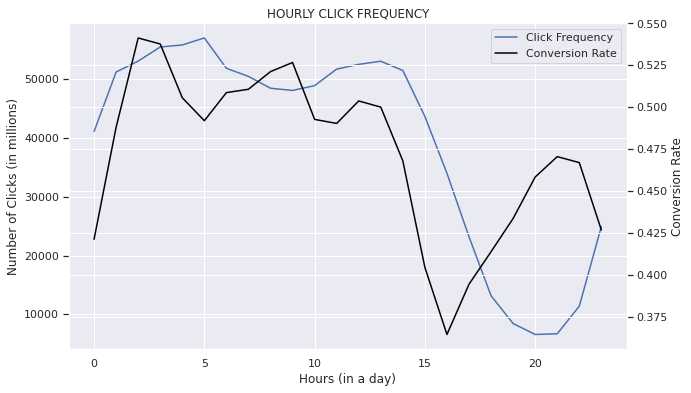

In [ ]:
fig, ax1 = plt.subplots(figsize=(10,6))

# create the first axis and plot the click frequency
ax1.set_xlabel('Hours (in a day)')
ax1.set_ylabel('Number of Clicks (in millions)')
click_freq_line = ax1.plot(final_training_sample_v2[['hourly_click_time', 'is_attributed']].groupby(['hourly_click_time'], as_index=True).count(), label='Click Frequency')
ax1.tick_params(axis='y')

# create the second axis and plot the conversion rate
ax2 = ax1.twinx()
ax2.set_ylabel('Conversion Rate')
conversion_rate_line = ax2.plot(final_training_sample_v2[['hourly_click_time', 'is_attributed']].groupby(['hourly_click_time'], as_index=True).mean(), color='black', label='Conversion Rate')
ax2.tick_params(axis='y')

# add legends to the plot
lines = click_freq_line + conversion_rate_line
labels = [l.get_label() for l in lines]
ax1.legend(lines, labels, loc='best')

# add a title to the plot
plt.title('HOURLY CLICK FREQUENCY')

# show the plot
plt.show()

**Inference from the plot:**

The plot reveals that during the first half of the day, both the click counts and conversion rates are higher compared to the second half. Additionally, there is a declining trend in both variables that begins in the middle of the day and reaches its lowest point around the evening hours (between the 15th and 20th hour). However, we can observe an increase in both variables as the day is about to end.

## **Step 4:** Feature Engineering 

Beyond the feature modifications already made, we made minimum changes to our features to get an idea of our baseline that we should start from. 

### Building new feature: hourly_click_time

The `hourly_click_time` column in the dataframe uses the round function to derive its values. It rounds the `click_time` column to the nearest hour. This means that all clicks that happened within the same hour will have the same value in the `hourly_click_time` column.

Now, we want to preserve the individual hour values for each click. We can do this by the following code:

In [ ]:
print('Extracting new features for hour and day')
final_training_sample_v2['hour'] = pd.to_datetime(final_training_sample_v2.click_time).dt.hour.astype('uint8')
final_training_sample_v2['day'] = pd.to_datetime(final_training_sample_v2.click_time).dt.day.astype('uint8')

# we can still use `click_time` later in the project, so instead of dropping, lets keep it 
# df_7_8_day.drop('click_time', axis = 1, inplace = True) 

Extracting new features for hour and day


In [ ]:
final_training_sample_v2.day.unique()

array([6, 7, 8, 9], dtype=uint8)

### Additional Feature Engineering for later

We tend to create new variables, such as `channel_by_ip_day_hour` which will represent the count of unique channels for each combination of `ip`, `day`, and `hour`. We will essentially count how many different channels were clicked by a unique IP address in a given hour of a given day. We plan to create similar features for different combinations of the variables, where we will group the hour and day and combine the variables from the dataset. 

These feature can be useful as they can help identify what combinations of `IPs`, `channels`, `os`, `device`, and `app` are repeatedly clicking on ads within a short period of time, which could indicate fraudulent activity.

## **Step 5:** Baseline Models



Although the final test data set consist of values indicating the probability a user will download an app, the train data set uses a binary classifier to indicate whether a user downloaded the app. A value of 1 is assigned to the clicks that led to a download, while a value of 0 indicates a click did not lead to a download. Due to the nature of the binary classification, a logistic regression model was selected to be the baseline model evaluation. We attempted to also look at a KNN and Random Forest as two additional baseline models. 

In [ ]:
dtypes = {
    'ip': 'uint32',
    'app': 'uint16',
    'device': 'uint16',
    'os': 'uint16',
    'channel': 'uint16',
    'click_time': 'str',
    'attributed_time': 'str',
    'is_attributed': 'uint8'
}

training_data = pd.read_csv('final_training_sample.csv', dtype=dtypes)

In [ ]:
# splitting feature and variables

train = training_data.iloc[:, 2:6]
labels = training_data.iloc[:, -1]

###Logistic Regression using SGD

In [ ]:
# splitting train and test data
enc = OneHotEncoder(handle_unknown='ignore')
enc_train = enc.fit_transform(train)
print(enc_train.shape, labels.shape)

lr_x_train, lr_x_test, lr_y_train, lr_y_test = train_test_split(enc_train, labels, test_size=0.2,  random_state=42)

print(lr_x_train.shape, lr_y_train.shape)
print(lr_x_test.shape, lr_y_test.shape)

(942229, 232735) (942229,)
(753783, 232735) (753783,)
(188446, 232735) (188446,)


In [ ]:
## creating logistic regression model with stochastic gradient descent (SGD) learning

model = SGDClassifier(loss='log_loss', validation_fraction=0.2).fit(lr_x_train, lr_y_train)
val_scores = cross_val_score(model, lr_x_train, lr_y_train)

In [ ]:
## Making prediction off model
lr_y_pred = model.predict(lr_x_train)
lr_y_pred_prob = model.predict_proba(lr_x_train)
accuracy = model.score(lr_x_train, lr_y_train)

In [ ]:
# Displaying results of predictions

pred = pd.DataFrame(lr_y_pred, columns=["prediction_no_enc"])
pred_prob = pd.DataFrame(lr_y_pred_prob[:, 1], columns=['predicted_probability_no_enc'])

results_table = pd.concat([pred, pred_prob], ignore_index=True, axis=1, )
results_table.columns = ['prediction_no_enc', 'predicted_probability_no_enc']
results_table.head()

,prediction_no_enc,predicted_probability_no_enc
0,0,0.079142
1,1,0.995366
2,0,0.169803
3,0,0.246273
4,0,0.104102


In [ ]:
# Calculating accuracies
val_accuracy_df = pd.DataFrame({'validation_accuracy': val_scores})
train_accuracy_df = pd.DataFrame({'training_accuracy': accuracy}, index=[1])
test_accuracy = model.score(lr_x_test, lr_y_test)
test_accuracy_df = pd.DataFrame({'test_accuracy': test_accuracy}, index=[1])

In [ ]:
# Displaying model results
val_accuracy_df_styler = val_accuracy_df.style.set_table_attributes("style='display:inline'").set_caption("Validation Scores")
train_accuracy_df_styler = train_accuracy_df.style.set_table_attributes("style='display:inline'").set_caption("Traing Accuracy")
test_accuracy_df_styler = test_accuracy_df.style.set_table_attributes("style='display:inline'").set_caption("Test Accuracy")

display_html(val_accuracy_df_styler._repr_html_()+train_accuracy_df_styler._repr_html_() +test_accuracy_df_styler._repr_html_(), raw=True)

,validation_accuracy
0,0.902359
1,0.902366
2,0.903036
3,0.904064
4,0.902730
,training_accuracy
1,0.903078
,test_accuracy
1,0.904673


###KNN Model

In [ ]:
# sampling 100,000 records and splitting into train/test data sets
knn_x_train = train.sample(100000)
knn_y_train = labels[knn_x_train.index]

# one hot encoding categorial features
enc = OneHotEncoder(handle_unknown='ignore')
knn_x_train = enc.fit_transform(knn_x_train)

# spliting data
knn_x_train, knn_x_test, knn_y_train, knn_y_test = train_test_split(knn_x_train, knn_y_train, test_size=0.2,  random_state=42)

print(knn_x_train.shape, knn_y_train.shape)
print(knn_x_test.shape, knn_y_test.shape)

NameError: ignored

In [ ]:
# crearing/fitting model
knn_model = KNeighborsClassifier(n_jobs=-1).fit(knn_x_train, knn_y_train)
knn_val_scores = cross_val_score(knn_model, knn_x_train, knn_y_train)

In [ ]:
# making predictions off model
knn_y_pred = knn_model.predict(knn_x_train)
knn_y_pred_prob = knn_model.predict_proba(knn_x_train)
knn_accuracy = knn_model.score(knn_x_train, knn_y_train) 

In [ ]:
# Displaying predictions
knn_pred = pd.DataFrame(knn_y_pred)
knn_pred_prob = pd.DataFrame(knn_y_pred_prob[:,1]) 
knn_results_df = pd.concat([knn_pred, knn_pred_prob], axis=1)
knn_results_df.columns = ['knn_predictions', 'knn_predicted_probabilities']
knn_results_df.head()

In [ ]:
# Calculating accuracies
knn_val_scores = pd.DataFrame({'knn_validation_accuracy': knn_val_scores})
knn_train_accuracy_df = pd.DataFrame({'knn_training_accuracy': knn_accuracy}, index=[1])
knn_test_accuracy = knn_model.score(knn_x_test, knn_y_test)
knn_test_accuracy_df = pd.DataFrame({'knn_test_accuracy': knn_test_accuracy}, index=[1])


In [ ]:
# Displaying model results
knn_val_accuracy_df_styler = knn_val_scores.style.set_table_attributes("style='display:inline'").set_caption("Validation Scores")
knn_train_accuracy_df_styler = knn_train_accuracy_df.style.set_table_attributes("style='display:inline'").set_caption("Traing Accuracy")
knn_test_accuracy_df_styler = knn_test_accuracy_df.style.set_table_attributes("style='display:inline'").set_caption("Test Accuracy")

display_html(knn_val_accuracy_df_styler._repr_html_()+knn_train_accuracy_df_styler._repr_html_() + knn_test_accuracy_df_styler._repr_html_(), raw=True)

###Random Forest Model

In [ ]:
# sampling 100,000 records from the full dataset
rf_x_train = train.sample(100000)
rf_y_train = labels[rf_x_train.index]


# one hot encoding categorial features
rf_x_train = enc.fit_transform(rf_x_train)
rf_x_train, rf_x_test, rf_y_train, rf_y_test = train_test_split(rf_x_train, rf_y_train, test_size=0.2,  random_state=42)

print(rf_x_train.shape, rf_y_train.shape)
print(rf_x_test.shape, rf_y_test.shape)


(80000, 80925) (80000,)
(20000, 80925) (20000,)


In [ ]:
# creating/fitting model
rf_model = RandomForestClassifier(max_depth=5, min_samples_leaf=100, bootstrap=False, n_jobs=-1, random_state=123)

rf_val_scores = cross_val_score(rf_model, rf_x_train, rf_y_train) 
rf_model.fit(rf_x_train, rf_y_train) 

In [ ]:
# making model predictions
rf_y_pred = rf_model.predict(rf_x_train)
rf_y_pred_prob = rf_model.predict_proba(rf_x_train)
rf_accuracy = rf_model.score(rf_x_train, rf_y_train)

In [ ]:
# Displaying model predictions
rf_pred = pd.DataFrame(rf_y_pred)
rf_pred_prob = pd.DataFrame(rf_y_pred_prob[:,1])
rf_results_df = pd.concat([rf_pred, rf_pred_prob], axis=1)
rf_results_df.columns = ['rf_predictions', 'rf_predicted_probabilities']
rf_results_df.head()

,rf_predictions,rf_predicted_probabilities
0,0,0.485180
1,0,0.483529
2,0,0.484840
3,0,0.488862
4,0,0.484840


In [ ]:
# Evaluating model results
rf_val_scores = pd.DataFrame({'rf_validation_accuracy': rf_val_scores})
rf_train_accuracy_df = pd.DataFrame({'rf_training_accuracy': rf_accuracy}, index=[1])
rf_test_accuracy = rf_model.score(rf_x_test, rf_y_test)
test_accuracy_df = pd.DataFrame({'rf_test_accuracy': rf_test_accuracy}, index=[1])

In [ ]:
# Displaying model results
rf_val_scores_styler = rf_val_scores.style.set_table_attributes("style='display:inline'").set_caption("Validation Scores")
rf_train_accuracy_df_styler = rf_train_accuracy_df.style.set_table_attributes("style='display:inline'").set_caption("Traing Accuracy")
test_accuracy_df_styler = test_accuracy_df.style.set_table_attributes("style='display:inline'").set_caption("Test Accuracy")

display_html(rf_val_scores_styler._repr_html_()+rf_train_accuracy_df_styler._repr_html_() + test_accuracy_df_styler._repr_html_(), raw=True)

## **Step 6:** Evaluate Models

In [1]:
print(f"The test accuracy of Logistic Regression with SGD: \t\t{test_accuracy*100:.2f}%")
print(f"The test accuracy of KNN: \t\t\t\t\t{knn_test_accuracy*100:.2f}%")
print(f"The test accuracy of Random Forest: \t\t\t\t{rf_test_accuracy*100:.2f}%")

NameError: ignored

###Conclusions
To ensure the analysis selected a strong baseline, three initial models were considered:
  - Logistic Regression using SGD
  - K Nearest Nieghbor
  - Random Forest

Each model utilized a Onehot Encoded training set of four features:
  - app
  - device
  - os
  - channel

Additionally, with an exception of a few parameters, each model was run utilizing the primary default Scikit-Learn parameters to allow for optimization of valiation testing, learning rate, etc. Finally, while Logistic Regression was run using the entire training set, KNN and Random Forest had to be run using a random sample of 100,000 records due to computing limitations. Based on the accuracies of our three intitial baselines, it appears Logistic Regression with SGD or KNN are our strongest baseline models with more than a 90% test accuracy. 

## **Step 7:** Thoughts and Next Steps

As experienced when running KNN and Random Forest models, we face computing limitation due to the size of the data set. Moving forward, it'll be advantageous to explore batch processing to allow for learning based on the full data set. This will allow for the utilization of more advance ML models such at nueral networks.

The initial baselines for KNN and Logistic Regression produced roughly 91% accuracy using 4 core features, without any feature engineering. When seeking to optimize our final model, the results may further be improved by using derived features, such as the hour at which an ad was clicked or the device the click occured on. Our next steps will include hyperparamter optimization, where we deviate away from default parameter values in an effort to find superior values that are ideal for the unique characteristics of our data set. 